## Imports

In [1]:
import json
import random
from pathlib import Path
from collections import Counter, defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt

## Configuration & Setup

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

LABEL_DIR = Path("tt100k_yolo/labels/train")
IMG_DIR = Path("tt100k_yolo/images/train")
ANN_PATH = Path("tt100k_2021/annotations_all.json")

## Load Annotations & Extract Classes

In [3]:
with open(ANN_PATH, "r") as f:
    ann = json.load(f)

imgs = ann["imgs"]
print("Total annotated images:", len(imgs))

Total annotated images: 10592


## Class Mapping & Analysis

This section loads the annotation data and creates mappings between class names and their numeric IDs.

In [4]:
classes = sorted({obj["category"] for img in imgs.values() for obj in img["objects"]})

class2id = {c: i for i, c in enumerate(classes)}
id2class = {i: c for c, i in class2id.items()}

print("Number of classes:", len(classes))
print(class2id)

Number of classes: 201
{'i1': 0, 'i10': 1, 'i11': 2, 'i12': 3, 'i13': 4, 'i14': 5, 'i15': 6, 'i2': 7, 'i2r': 8, 'i3': 9, 'i4': 10, 'i4l': 11, 'i5': 12, 'il100': 13, 'il110': 14, 'il50': 15, 'il60': 16, 'il70': 17, 'il80': 18, 'il90': 19, 'im': 20, 'ip': 21, 'iz': 22, 'p1': 23, 'p10': 24, 'p11': 25, 'p12': 26, 'p13': 27, 'p14': 28, 'p15': 29, 'p16': 30, 'p17': 31, 'p18': 32, 'p19': 33, 'p1n': 34, 'p2': 35, 'p20': 36, 'p21': 37, 'p23': 38, 'p24': 39, 'p25': 40, 'p26': 41, 'p27': 42, 'p28': 43, 'p29': 44, 'p3': 45, 'p4': 46, 'p5': 47, 'p6': 48, 'p7': 49, 'p8': 50, 'p9': 51, 'pa10': 52, 'pa12': 53, 'pa13': 54, 'pa14': 55, 'pa18': 56, 'pa6': 57, 'pa8': 58, 'pb': 59, 'pbm': 60, 'pbp': 61, 'pc': 62, 'pcd': 63, 'pcl': 64, 'pclr': 65, 'pcr': 66, 'pcs': 67, 'pctl': 68, 'pdd': 69, 'pg': 70, 'ph1.8': 71, 'ph2': 72, 'ph2.1': 73, 'ph2.2': 74, 'ph2.4': 75, 'ph2.5': 76, 'ph2.6': 77, 'ph2.8': 78, 'ph2.9': 79, 'ph3': 80, 'ph3.2': 81, 'ph3.3': 82, 'ph3.5': 83, 'ph3.8': 84, 'ph4': 85, 'ph4.2': 86, 'ph4.3'

## Analyze class distribution from YOLO label files

In [5]:
label_files = sorted(list(LABEL_DIR.glob("*.txt")))
image_files = sorted(list(IMG_DIR.glob("*.jpg")))

n_label_files = len(label_files)
n_image_files = len(image_files)

print(f"Label files found: {n_label_files}")
print(f"Image files found: {n_image_files}")

Label files found: 8473
Image files found: 8473


## Class Distribution Analysis

This section analyzes the distribution of object classes in the dataset by reading YOLO format label files and counting class instances.

In [6]:
class_counter = Counter()
example_label_preview = None
for label_file in label_files:
    with open(label_file) as f:
        lines = [ln.strip() for ln in f if ln.strip()]
        if not example_label_preview and lines:
            example_label_preview = lines[:10]
        for line in lines:
            try:
                cls_id = int(line.split()[0])
                class_counter[cls_id] += 1
            except:
                pass

total_annotations = sum(class_counter.values())
print("class_counter (id -> count):", dict(class_counter))
print("Total annotations:", total_annotations)

class_counter (id -> count): {72: 9, 103: 510, 41: 677, 42: 106, 144: 37, 89: 140, 105: 1130, 138: 28, 61: 77, 21: 282, 47: 343, 132: 2547, 25: 1258, 172: 81, 51: 52, 119: 133, 10: 641, 110: 119, 111: 732, 16: 397, 17: 11, 18: 245, 85: 90, 97: 549, 107: 833, 7: 378, 134: 1909, 20: 56, 69: 35, 70: 127, 194: 187, 45: 147, 12: 1392, 121: 83, 23: 68, 108: 674, 26: 151, 31: 24, 32: 54, 133: 5, 14: 14, 19: 59, 99: 242, 192: 340, 24: 285, 116: 24, 190: 134, 8: 347, 101: 124, 160: 99, 11: 267, 27: 309, 127: 114, 197: 75, 148: 18, 106: 446, 66: 14, 30: 16, 174: 95, 59: 64, 166: 48, 13: 113, 91: 94, 98: 37, 193: 76, 62: 5, 38: 239, 60: 53, 147: 65, 102: 7, 104: 21, 140: 162, 183: 27, 113: 1, 76: 11, 64: 67, 180: 23, 83: 9, 82: 21, 167: 46, 181: 7, 126: 9, 86: 22, 125: 14, 44: 27, 63: 17, 171: 17, 145: 10, 50: 11, 100: 73, 54: 19, 159: 1, 55: 50, 48: 86, 93: 2, 33: 109, 173: 2, 198: 3, 80: 26, 185: 37, 114: 39, 15: 28, 46: 3, 177: 3, 122: 3, 137: 1, 34: 7, 1: 56, 143: 33, 169: 12, 175: 14, 152: 1

In [7]:
print("Class counts:")
for iid, cnt in sorted(class_counter.items()):
    print(f"  ID {iid} -> {id2class.get(iid,'UNKNOWN')}: {cnt}")

Class counts:
  ID 0 -> i1: 5
  ID 1 -> i10: 56
  ID 2 -> i11: 3
  ID 3 -> i12: 21
  ID 4 -> i13: 13
  ID 5 -> i14: 4
  ID 6 -> i15: 4
  ID 7 -> i2: 378
  ID 8 -> i2r: 347
  ID 9 -> i3: 6
  ID 10 -> i4: 641
  ID 11 -> i4l: 267
  ID 12 -> i5: 1392
  ID 13 -> il100: 113
  ID 14 -> il110: 14
  ID 15 -> il50: 28
  ID 16 -> il60: 397
  ID 17 -> il70: 11
  ID 18 -> il80: 245
  ID 19 -> il90: 59
  ID 20 -> im: 56
  ID 21 -> ip: 282
  ID 22 -> iz: 18
  ID 23 -> p1: 68
  ID 24 -> p10: 285
  ID 25 -> p11: 1258
  ID 26 -> p12: 151
  ID 27 -> p13: 309
  ID 28 -> p14: 39
  ID 29 -> p15: 3
  ID 30 -> p16: 16
  ID 31 -> p17: 24
  ID 32 -> p18: 54
  ID 33 -> p19: 109
  ID 34 -> p1n: 7
  ID 35 -> p2: 13
  ID 36 -> p20: 2
  ID 37 -> p21: 1
  ID 38 -> p23: 239
  ID 39 -> p24: 2
  ID 40 -> p25: 39
  ID 41 -> p26: 677
  ID 42 -> p27: 106
  ID 43 -> p28: 2
  ID 44 -> p29: 27
  ID 45 -> p3: 147
  ID 46 -> p4: 3
  ID 47 -> p5: 343
  ID 48 -> p6: 86
  ID 49 -> p7: 1
  ID 50 -> p8: 11
  ID 51 -> p9: 52
  ID 52 

## Object Count Distribution

This section visualizes how many objects appear per image, showing a histogram of the distribution of object counts across all images in the dataset.

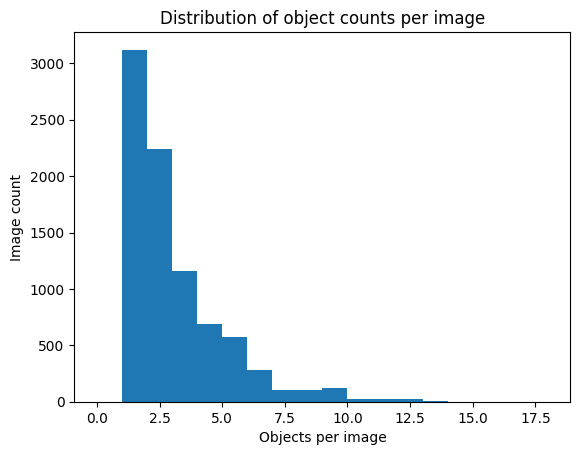

In [8]:
image_counts = defaultdict(int)
for label_file in label_files:
    with open(label_file) as f:
        for _ in f:
            image_counts[label_file.stem] += 1

counts = list(image_counts.values()) if image_counts else [0]
plt.hist(counts, bins=range(0, max(counts)+2 if counts else 2))
plt.xlabel('Objects per image')
plt.ylabel('Image count')
plt.title('Distribution of object counts per image')
plt.show()

## Class Distribution Visualization

This section creates a bar chart showing the distribution of object instances across all classes in the dataset.

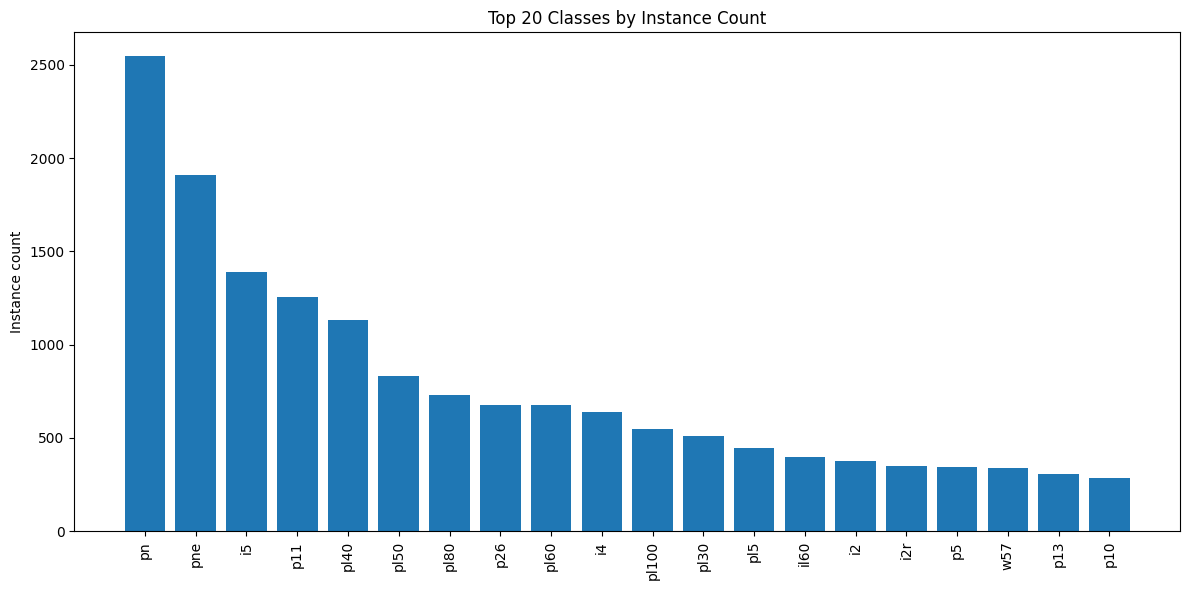

In [18]:
top_n = 20
sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_classes = [id2class.get(i, str(i)) for i, _ in sorted_items]
top_counts = [cnt for _, cnt in sorted_items]

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(top_classes, top_counts)
ax.set_ylabel("Instance count")
ax.set_title(f"Top {top_n} Classes by Instance Count")

plt.xticks(rotation=90, ha="center", fontsize=10)
plt.tight_layout()
plt.show()

## Sample Image Visualization

This section randomly samples images from the dataset and visualizes them with their bounding box annotations. Each bounding box is drawn with the corresponding class ID label.

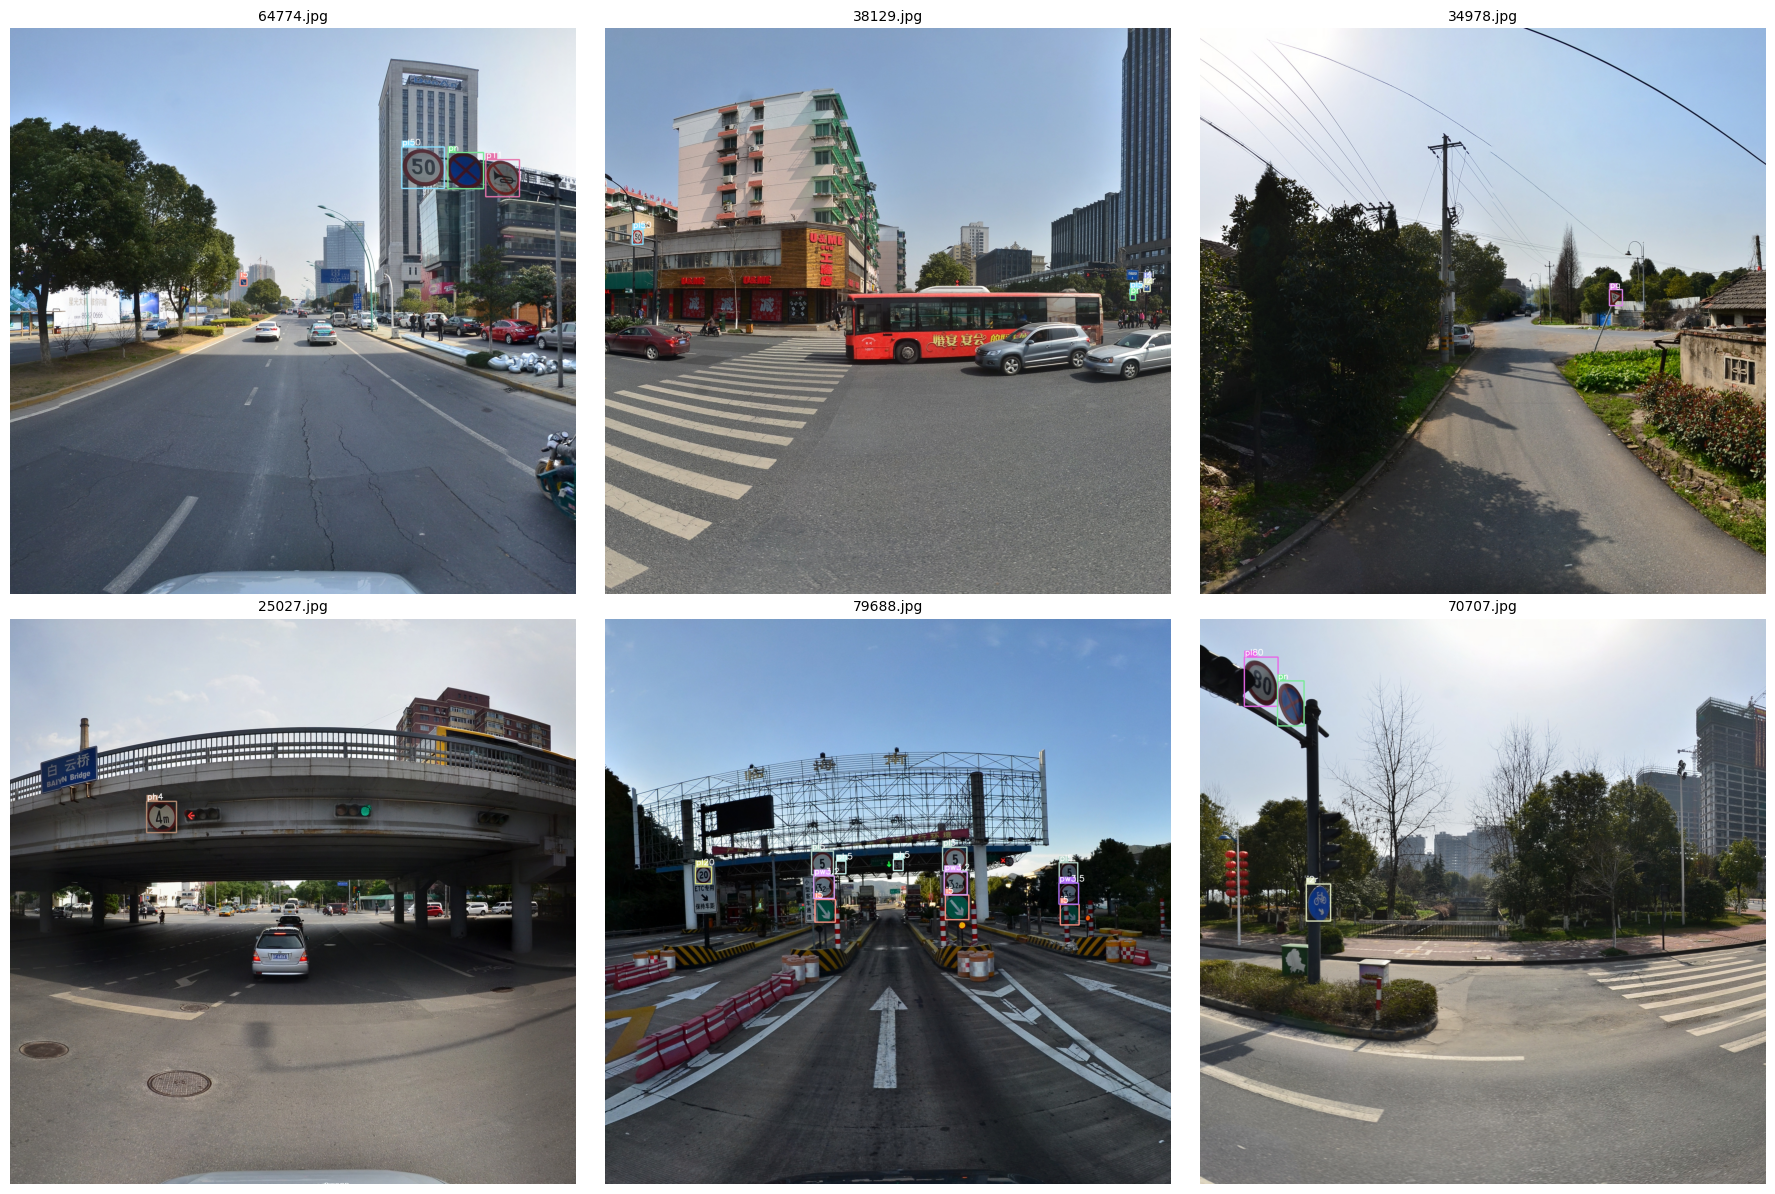

In [22]:
SAMPLES = 6
image_list = [
    p for p in IMG_DIR.glob("*.jpg") if (LABEL_DIR / (p.stem + ".txt")).exists()
]
sample_imgs = random.sample(image_list, min(SAMPLES, len(image_list)))

# Create a color map for different classes
np.random.seed(RANDOM_SEED)
colors = {
    i: tuple(np.random.randint(100, 255, 3).tolist()) for i in class_counter.keys()
}

# Create subplot grid
n_cols = 3
n_rows = (len(sample_imgs) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if len(sample_imgs) > 1 else [axes]

for idx, img_p in enumerate(sample_imgs):
    img = cv2.imread(str(img_p))
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(LABEL_DIR / (img_p.stem + ".txt")) as f:
        for ln in f:
            parts = ln.split()
            if len(parts) < 5:
                continue
            cls, xc, yc, bw, bh = map(float, parts[:5])
            cls_id = int(cls)

            # Calculate bounding box coordinates
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)

            # Use color from color map
            color = colors.get(cls_id, (0, 255, 0))

            # Draw thicker rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

            # Get class name
            label = id2class.get(cls_id, str(cls_id))

            # Add text with background for better readability
            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
            text_x = x1
            text_y = max(text_size[1] + 5, y1 - 5)

            # Draw filled rectangle as background
            cv2.rectangle(
                img,
                (text_x, text_y - text_size[1] - 4),
                (text_x + text_size[0] + 4, text_y + 2),
                color,
                -1,
            )

            # Draw text
            cv2.putText(
                img,
                label,
                (text_x + 2, text_y - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                2,
            )

    # Display image
    axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"{img_p.name}", fontsize=10)
    axes[idx].axis("off")

# Hide unused subplots
for idx in range(len(sample_imgs), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## Key Findings from EDA

### Dataset Overview
- The TT100K dataset contains a comprehensive collection of traffic sign images with YOLO format annotations
- Both training images and corresponding label files are available in the dataset
- Multiple traffic sign classes are present with varying frequencies

### Class Distribution Insights
- **Class Imbalance**: The dataset exhibits significant class imbalance, with some traffic sign types appearing much more frequently than others
- **Top Classes**: The top 20 most common traffic sign classes dominate the dataset, representing the majority of annotations
- **Long Tail Distribution**: Many traffic sign classes have relatively few instances, which may impact model performance on rare sign types

### Object Density Analysis
- **Objects per Image**: The distribution of object counts per image shows variability
- Most images contain multiple traffic signs, indicating real-world urban scenarios
- Some images have dense annotations while others are more sparse

### Annotation Quality
- Bounding boxes are properly formatted in YOLO format (class_id, x_center, y_center, width, height)
- Annotations cover various traffic sign types with clear class mappings
- Visual inspection shows that bounding boxes accurately capture traffic sign locations